In [1]:
# import packages
import os
from glob import glob
import geopandas as gpd
from pathlib import Path
from typing import List, Union
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
import rasterio as rio
import datetime
from datetime import datetime, timedelta
import sys
import pandas as pd
import seaborn as sns
from scipy.stats import linregress

In [2]:
vertical_fn = './vertical_velocity_imja.tif'
vertical_veloc_da = rioxarray.open_rasterio(vertical_fn).squeeze()

In [3]:
dem_fn = '../data/data_igrams/012_023790_IW1/20170123_20170204/S1_023790_IW1_20170123_20170204_VV_INT20_FFTS/S1_023790_IW1_20170123_20170204_VV_INT20_FFTS_dem_imja.tif'
dem_da = rioxarray.open_rasterio(dem_fn).squeeze()
elev_above_lake = dem_da-4961

In [4]:
elev_above_lake = elev_above_lake.rio.reproject_match(vertical_veloc_da)

In [5]:
#elev_above_lake = elev_above_lake.where(elev_above_lake >= 0)
vertical_veloc_da = vertical_veloc_da.where(vertical_veloc_da >= 0)

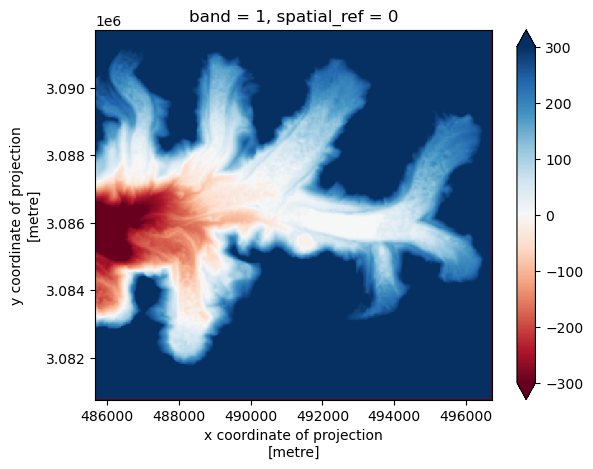

In [6]:
elev_above_lake.plot(vmin=-300, vmax=300, cmap='RdBu')

In [7]:
years_until_lake_level = elev_above_lake/vertical_veloc_da
# adjust to relative to 2024 based on 2013 DEM timestamp (real timestamp 2011-2015)
years_until_lake_level = years_until_lake_level - 11
# mask areas moving upward
years_until_lake_level = years_until_lake_level.where(vertical_veloc_da >= 0, 100000)
# mask areas already below lake level
years_until_lake_level = years_until_lake_level.where(elev_above_lake >= 0, 0)

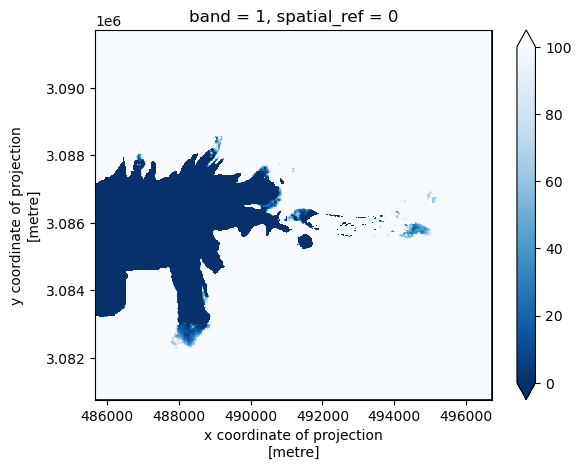

In [8]:
f, ax = plt.subplots()
years_until_lake_level.plot(ax=ax, vmin=0, vmax=100, cmap='Blues_r')

In [9]:
years_until_lake_level.rio.to_raster('imja_years_until_lake_level.tif')